In [1]:
import sys
import os

file_path = os.getcwd()
parent_dir = os.path.split(file_path)[0]
sys.path.insert(0, parent_dir + "/hpt/")
sys.path.insert(0, parent_dir + "/knockpy/")
import hpt

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

import knockpy

In [126]:
def calc_mean_sem(data, group_vals, meas):
    """
    Groups data by group_vals and then calculates mean, standard error
    for each column.
    """
    agg_df = data.groupby(group_vals)[meas].agg(['mean', 'sem']).reset_index()
    for m in meas:
        agg_df[f'{m}_mean'] = agg_df[m]['mean']
        agg_df[f'{m}_se'] = agg_df[m]['sem']
        agg_df[f'{m}_ymin'] =  np.maximum(0, agg_df[f'{m}_mean'] - 2*agg_df[f'{m}_se'])
        agg_df[f'{m}_ymax'] =  agg_df[f'{m}_mean'] + 2*agg_df[f'{m}_se']
    
    return agg_df.loc[:, agg_df.columns.get_level_values(1) == '']

## 2.2 Example plots

### 2.2.1 Changepoint example

In [19]:
# Generate data
np.random.seed(123) # original good one
T = 100
delta = 0.75 # original: 1.75
X = np.arange(T)
Y = np.random.randn(T)
Y[int(T/2):] += delta
mu = np.zeros(T)
mu[int(T/2):] += delta

In [15]:
# # Plot #1
# df = pd.DataFrame()
# df['X'] = X
# df['Y'] = Y
# fig, ax = plt.subplots(figsize=(3,2))
# ax = sns.regplot(
#     ax=ax,
#     data=df, 
#     x='X', 
#     y='Y', 
#     color='#6495ED',
#     label='Y',
#     line_kws={'color':'seagreen'},
# )
# #ax = lmplot.axes[0, 0]
# ax.plot(X[0:int(T/2)], mu[0:int(T/2)],
#     color='red',
#     label='True mean',
#     linestyle='dashed'
# )
# ax.plot(X[int(T/2):], mu[int(T/2):],
#     color='red',
#     linestyle='dashed'
# )
# ax.set(xlabel='t', ylabel='Y')
# ax.legend()
# #plt.savefig("final-plots/changepoint_example.png", dpi=500)

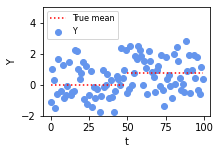

In [35]:
# Plot #2
fig, ax = plt.subplots(figsize=(3,2))
ax.scatter(X, Y, label='Y', color='#6495ED')
ax.plot(X[0:int(T/2)], mu[0:int(T/2)],
    color='red',
    label='True mean',
    linestyle='dotted'
)
ax.plot(X[int(T/2):], mu[int(T/2):],
    color='red',
    linestyle='dotted'
)
ax.set(ylabel='Y', xlabel='t')
ax.set_ylim(-2, 5)
ax.legend(loc=(2), prop={'size': 8})
#plt.show()
plt.savefig("final-plots/changepoint_example.png", dpi=500)

### 2.2.2 Astro Example

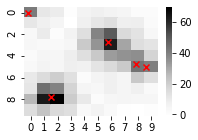

In [258]:
import scipy.signal 

# Create x, y
p = 10
z = np.zeros((p, p))
x = np.arange(p).reshape(-1, 1)
x = np.repeat(x, p, axis=1)
y = x.T

# Create point sources
np.random.seed(110)
# k = 15
# xsource = 10*np.random.uniform(size=(k,))
# ysource = 10*np.random.uniform(size=(k,))
# magsource = 20 + np.abs(10*np.random.randn(k))


xsource = [0.5, 8.25, 5.234, 5.5398, 3.234097]
ysource = [0.25, 2, 8.357098, 9.12309, 6.2509]
magsource = [50, 100, 35, 25, 83]

# Create means 
mu = z.copy()
for (i, j, mag) in zip(xsource, ysource, magsource):
    d = np.sqrt(np.power(i-x-0.5, 2) + np.power(j-y-0.5,2))
    mu += mag * np.exp(-1*d)


# Create data
D = np.sqrt(mu) * np.random.randn(p, p) + mu #3*np.random.randn(p, p) + mu

# Plot
fig, ax = plt.subplots(figsize=(3,2))
ax = sns.heatmap(D, cmap='Greys', ax=ax)
ax.scatter(ysource, xsource, color='red', marker='x', label='True Sources')
#ax.legend(bbox_to_anchor=(1.1, 1.3))
plt.savefig("final-plots/astro_example.png", dpi=500)

## 2.3 Integer-relaxation plots

In [137]:
import numpy as np
import pandas as pd
from plotnine import *

day = '2021-11-09'
t = '00-20-38' 

data = pd.read_csv(f"data/lp_int_sol/{day}/{t}/results.csv")

In [180]:
id_vars = ['kappa', 'p', 'sparsity', 'covmethod']
#cov_dict = {'ar1':'AR1', 'ver':'ErdosRenyi (Cov.)', 'qer':'ErdosRenyi (Prec.)'}
cov_dict = {'ar1':'AR1', 'ver':'VER', 'qer':'QER'}

### Averages of number of randomized pairs/singletons

In [182]:

mdata = pd.melt(
    data[id_vars + ['n_rand_pairs', 'n_singleton']],
    id_vars=id_vars,
    var_name='variable',
    value_name='value'
)

,kappa,p,sparsity,covmethod,variable,value
0,0.05,1000,0.05,ar1,n_rand_pairs,1
1,0.05,1000,0.05,ar1,n_rand_pairs,0
2,0.05,1000,0.05,ar1,n_rand_pairs,0
3,0.05,1000,0.05,ar1,n_rand_pairs,1
4,0.05,1000,0.05,ar1,n_rand_pairs,1
...,...,...,...,...,...,...
475,1.00,1000,0.05,qer,n_singleton,0
476,1.00,1000,0.05,qer,n_singleton,0
477,1.00,1000,0.05,qer,n_singleton,0
478,1.00,1000,0.05,qer,n_singleton,0


### Averages of objective function

In [171]:
meas_dict = {
    'epower_lp':'Relaxed LP',
    'epower_ilp':'LP + iLP',
    'epower_sample':'LP + sampling'
}
meas = list(meas_dict.keys())
# melt
mdata = pd.melt(
    data[id_vars + meas],
    id_vars=id_vars,
    var_name='measurement',
    value_name='value'
)

agg_df = calc_mean_sem(
    mdata,
    group_vals=id_vars + ['measurement'], 
    meas=['value']
)
agg_df['measurement'] = agg_df['measurement'].map(meas_dict)
agg_df['covmethod'] = agg_df['covmethod'].map(cov_dict)
agg_df.head()

,kappa,p,sparsity,covmethod,measurement,value_mean,value_se,value_ymin,value_ymax
,,,,,,,,,
0,0.05,1000,0.05,AR1,LP + iLP,0.307460,0.091232,0.124995,0.489924
1,0.05,1000,0.05,AR1,Relaxed LP,0.424222,0.075052,0.274118,0.574327
2,0.05,1000,0.05,AR1,LP + sampling,0.399667,0.087356,0.224955,0.574380
3,0.05,1000,0.05,QER,LP + iLP,0.553791,0.147286,0.259219,0.848363
4,0.05,1000,0.05,QER,Relaxed LP,0.622845,0.137031,0.348782,0.896907


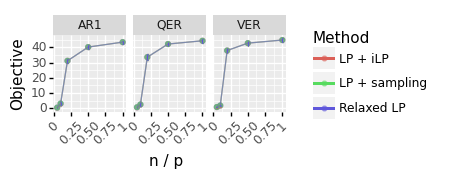

<ggplot: (8753969167047)>

In [179]:
g = (
    ggplot(
        agg_df, aes(x='kappa', y='value_mean', color='measurement')
    )
    + geom_point(alpha=0.5)
    + geom_line(alpha=0.5)
    + geom_errorbar(aes(ymin="value_ymin", ymax="value_ymax"), width=0.01)
    + facet_wrap("~covmethod")
    + labs(x=r'n / p', y='Objective', color='Method')
    + theme(
        figure_size=(3,1),
        axis_text_x=element_text(angle=45)
    )

)
g

### Trying to show distribution, this is trickier

In [120]:
['kappa', 'p', 'sparsity', 'covmethod']id_vars = [
    c for c in data.columns if c not in ['n_singleton', 'n_rand_pairs']
]
ndata = data.melt(
    id_vars=id_vars,
    value_name='num_nonzero'
)
# ndata['num_nonzero'] = ndata['num_nonzero'].astype(
#     pd.api.types.CategoricalDtype(categories=ndata['num_nonzero'].unique())
# )
ndata['variable'] = ndata['variable'].map({
    'n_singleton':'Singletons', 'n_rand_pairs':'Randomized pairs'
})
cdata = ndata.groupby(
    ['kappa', 'p', 'sparsity', 'covmethod', 'variable', 'num_nonzero']
)['seed'].count().reset_index()
cdata['seed'] = data['seed'] / np.unique(data['seed'].values).shape[0]
cdata = cdata.rename(columns=dict(seed='proportion'))
cdata.head()

,kappa,p,sparsity,covmethod,variable,num_nonzero,proportion
0,0.05,1000,0.05,ar1,Randomized pairs,0,0.0625
1,0.05,1000,0.05,ar1,Randomized pairs,1,0.1250
2,0.05,1000,0.05,ar1,Randomized pairs,2,0.1875
3,0.05,1000,0.05,ar1,Singletons,0,0.2500
4,0.05,1000,0.05,ar1,Singletons,1,0.3125


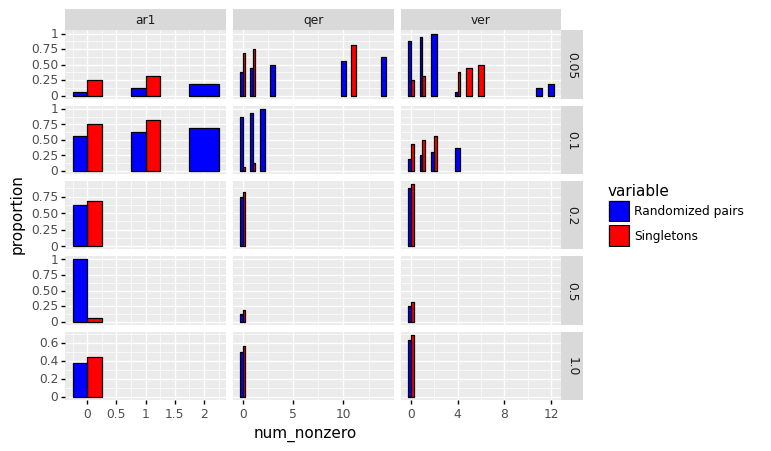

<ggplot: (8754020407459)>

In [121]:
cdata['strkappa'] = np.around(cdata['kappa'], 2).astype(str)
g = (
    ggplot(
        cdata, aes(x='num_nonzero', y='proportion', fill='variable')
    )
    + geom_col(position='dodge', color='black')
    + facet_grid("strkappa~covmethod", scales='free')
    + scale_fill_manual(['blue','red'])
)
g